# 09. Final Results - Cross-Method Consensus Analysis

Combine results from all detection methods:
- **PyOD**: IForest, LOF, ECOD (aggregated level)
- **HDBSCAN**: Clustering + outlier detection
- **Network**: Co-bidding, rotation, monopolistic relationships

**Output**: Summary statistics for thesis Chapter 3

In [1]:
import sys
sys.path.insert(0, '..')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from collections import Counter
from itertools import combinations
from datetime import datetime

from src.data_loader import load_tenders, load_buyers, load_suppliers

pd.set_option('display.max_columns', 50)
plt.style.use('seaborn-v0_8-whitegrid')

print(f"Started: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")

Started: 2026-02-07 13:32:12


## 1. Load Base Data

In [2]:
# Load reference data
buyers = load_buyers()
suppliers = load_suppliers()

print(f"Buyers: {len(buyers):,}")
print(f"Suppliers: {len(suppliers):,}")

Loaded buyers: 35,995
Loaded suppliers: 358,376
Buyers: 35,995
Suppliers: 358,376


## 2. Load PyOD Results

In [3]:
# Load PyOD high-consensus results
pyod_buyers = pd.read_csv('../results/aggregated_pyod_high_consensus_buyers.csv')
pyod_suppliers = pd.read_csv('../results/aggregated_pyod_high_consensus_suppliers.csv')
pyod_pairs = pd.read_csv('../results/aggregated_pyod_high_consensus_pairs.csv')

print("PyOD High-Consensus Results (all 3 algorithms agree):")
print(f"  Buyers: {len(pyod_buyers):,}")
print(f"  Suppliers: {len(pyod_suppliers):,}")
print(f"  Pairs: {len(pyod_pairs):,}")

# Create sets for consensus analysis
pyod_buyer_set = set(pyod_buyers['buyer_id'].tolist())
pyod_supplier_set = set(pyod_suppliers['supplier_id'].tolist())
pyod_pair_set = set(zip(pyod_pairs['buyer_id'], pyod_pairs['supplier_id']))

PyOD High-Consensus Results (all 3 algorithms agree):
  Buyers: 148
  Suppliers: 62
  Pairs: 5,882


## 3. Load HDBSCAN Results

In [4]:
# Load HDBSCAN suspicious entities
hdbscan_buyers = pd.read_csv('../results/hdbscan_suspicious_buyers.csv')
hdbscan_suppliers = pd.read_csv('../results/hdbscan_suspicious_suppliers.csv')
hdbscan_pairs = pd.read_csv('../results/hdbscan_suspicious_pairs.csv')

print("HDBSCAN Suspicious Results (outlier_score >= 0.5):")
print(f"  Buyers: {len(hdbscan_buyers):,}")
print(f"  Suppliers: {len(hdbscan_suppliers):,}")
print(f"  Pairs: {len(hdbscan_pairs):,}")

# For fair comparison, take top 5% (similar to PyOD contamination)
top_pct = 0.05
hdbscan_buyers_top = hdbscan_buyers.nlargest(int(len(buyers) * top_pct), 'outlier_score')
hdbscan_suppliers_top = hdbscan_suppliers.nlargest(int(len(suppliers) * top_pct), 'outlier_score')
# For pairs, use score threshold
hdbscan_pairs_top = hdbscan_pairs[hdbscan_pairs['outlier_score'] >= 0.8]

print(f"\nHDBSCAN Top 5%:")
print(f"  Buyers: {len(hdbscan_buyers_top):,}")
print(f"  Suppliers: {len(hdbscan_suppliers_top):,}")
print(f"  Pairs (score>=0.8): {len(hdbscan_pairs_top):,}")

# Create sets
hdbscan_buyer_set = set(hdbscan_buyers_top['buyer_id'].tolist())
hdbscan_supplier_set = set(hdbscan_suppliers_top['supplier_id'].tolist())
hdbscan_pair_set = set(zip(hdbscan_pairs_top['buyer_id'], hdbscan_pairs_top['supplier_id']))

HDBSCAN Suspicious Results (outlier_score >= 0.5):
  Buyers: 18,570
  Suppliers: 129,319
  Pairs: 606,904

HDBSCAN Top 5%:
  Buyers: 1,799
  Suppliers: 17,918
  Pairs (score>=0.8): 606,370


C:\Users\kachm\AppData\Local\Temp\ipykernel_5964\1223807087.py:4: DtypeWarning: Columns (0) have mixed types. Specify dtype option on import or set low_memory=False.
  hdbscan_pairs = pd.read_csv('../results/hdbscan_suspicious_pairs.csv')


## 4. Load Network Results

In [5]:
# Load network analysis results
network_suspicious = pd.read_csv('../results/network_suspicious_bidders.csv')
network_rotation = pd.read_csv('../results/network_bid_rotation.csv')
network_monopolistic = pd.read_csv('../results/network_monopolistic.csv')

print("Network Analysis Results:")
print(f"  Suspicious bidders (high connectivity): {len(network_suspicious):,}")
print(f"  Bid rotation pairs: {len(network_rotation):,}")
print(f"  Monopolistic relationships: {len(network_monopolistic):,}")

# Create sets - network flags suppliers (bidders)
network_supplier_set = set(network_suspicious['bidder_id'].tolist())

# For pairs - use monopolistic relationships
network_pair_set = set(zip(network_monopolistic['buyer_id'], network_monopolistic['supplier_id']))

Network Analysis Results:
  Suspicious bidders (high connectivity): 5,394
  Bid rotation pairs: 18,126
  Monopolistic relationships: 5,266


## 5. Cross-Method Consensus Analysis

In [6]:
# BUYER-LEVEL CONSENSUS
print("="*60)
print("BUYER-LEVEL CROSS-METHOD CONSENSUS")
print("="*60)

# Methods: PyOD (IForest+LOF+ECOD consensus), HDBSCAN
# Note: Network doesn't directly flag buyers

buyer_methods = {
    'PyOD (3/3)': pyod_buyer_set,
    'HDBSCAN': hdbscan_buyer_set,
}

# Count consensus
all_flagged_buyers = []
for method, buyer_ids in buyer_methods.items():
    all_flagged_buyers.extend(buyer_ids)
    print(f"{method}: {len(buyer_ids):,} buyers")

buyer_flag_counts = Counter(all_flagged_buyers)

print(f"\nConsensus:")
for threshold in range(1, len(buyer_methods) + 1):
    count = len([b for b, c in buyer_flag_counts.items() if c >= threshold])
    print(f"  >= {threshold} methods: {count:,} buyers")

# High consensus buyers (both methods agree)
high_consensus_buyers = [b for b, c in buyer_flag_counts.items() if c >= 2]
print(f"\nHigh-consensus buyers (both methods): {len(high_consensus_buyers)}")

BUYER-LEVEL CROSS-METHOD CONSENSUS
PyOD (3/3): 148 buyers
HDBSCAN: 1,799 buyers

Consensus:
  >= 1 methods: 1,947 buyers
  >= 2 methods: 0 buyers

High-consensus buyers (both methods): 0


In [7]:
# SUPPLIER-LEVEL CONSENSUS
print("="*60)
print("SUPPLIER-LEVEL CROSS-METHOD CONSENSUS")
print("="*60)

supplier_methods = {
    'PyOD (3/3)': pyod_supplier_set,
    'HDBSCAN': hdbscan_supplier_set,
    'Network': network_supplier_set,
}

all_flagged_suppliers = []
for method, supplier_ids in supplier_methods.items():
    all_flagged_suppliers.extend(supplier_ids)
    print(f"{method}: {len(supplier_ids):,} suppliers")

supplier_flag_counts = Counter(all_flagged_suppliers)

print(f"\nConsensus:")
for threshold in range(1, len(supplier_methods) + 1):
    count = len([s for s, c in supplier_flag_counts.items() if c >= threshold])
    print(f"  >= {threshold} methods: {count:,} suppliers")

# High consensus suppliers (3/3 methods)
high_consensus_suppliers = [s for s, c in supplier_flag_counts.items() if c >= 3]
print(f"\nHigh-consensus suppliers (all 3 methods): {len(high_consensus_suppliers)}")

SUPPLIER-LEVEL CROSS-METHOD CONSENSUS
PyOD (3/3): 62 suppliers
HDBSCAN: 17,918 suppliers
Network: 5,394 suppliers

Consensus:
  >= 1 methods: 22,696 suppliers
  >= 2 methods: 678 suppliers
  >= 3 methods: 0 suppliers

High-consensus suppliers (all 3 methods): 0


In [8]:
# PAIR-LEVEL CONSENSUS
print("="*60)
print("PAIR-LEVEL CROSS-METHOD CONSENSUS")
print("="*60)

pair_methods = {
    'PyOD (3/3)': pyod_pair_set,
    'HDBSCAN': hdbscan_pair_set,
    'Network (monopolistic)': network_pair_set,
}

all_flagged_pairs = []
for method, pairs in pair_methods.items():
    all_flagged_pairs.extend(pairs)
    print(f"{method}: {len(pairs):,} pairs")

pair_flag_counts = Counter(all_flagged_pairs)

print(f"\nConsensus:")
for threshold in range(1, len(pair_methods) + 1):
    count = len([p for p, c in pair_flag_counts.items() if c >= threshold])
    print(f"  >= {threshold} methods: {count:,} pairs")

# High consensus pairs
high_consensus_pairs = [p for p, c in pair_flag_counts.items() if c >= 2]
print(f"\nHigh-consensus pairs (>= 2 methods): {len(high_consensus_pairs)}")

PAIR-LEVEL CROSS-METHOD CONSENSUS
PyOD (3/3): 5,882 pairs
HDBSCAN: 606,370 pairs
Network (monopolistic): 5,266 pairs

Consensus:
  >= 1 methods: 615,727 pairs
  >= 2 methods: 1,725 pairs
  >= 3 methods: 66 pairs

High-consensus pairs (>= 2 methods): 1725


## 6. Jaccard Similarity Between Methods

In [9]:
def jaccard_index(set1, set2):
    """Calculate Jaccard similarity index."""
    if len(set1) == 0 and len(set2) == 0:
        return 0.0
    intersection = len(set1 & set2)
    union = len(set1 | set2)
    return intersection / union if union > 0 else 0.0

# SUPPLIER-LEVEL JACCARD MATRIX
print("SUPPLIER-LEVEL JACCARD SIMILARITY")
print("="*50)

supplier_method_names = list(supplier_methods.keys())
supplier_jaccard = pd.DataFrame(
    index=supplier_method_names,
    columns=supplier_method_names,
    dtype=float
)

for m1, m2 in combinations(supplier_method_names, 2):
    j = jaccard_index(supplier_methods[m1], supplier_methods[m2])
    supplier_jaccard.loc[m1, m2] = j
    supplier_jaccard.loc[m2, m1] = j
    intersection = len(supplier_methods[m1] & supplier_methods[m2])
    print(f"{m1} vs {m2}: J={j:.3f} ({intersection:,} common)")

for m in supplier_method_names:
    supplier_jaccard.loc[m, m] = 1.0

print("\nJaccard Matrix:")
display(supplier_jaccard.round(3))

SUPPLIER-LEVEL JACCARD SIMILARITY
PyOD (3/3) vs HDBSCAN: J=0.000 (8 common)
PyOD (3/3) vs Network: J=0.001 (4 common)
HDBSCAN vs Network: J=0.029 (666 common)

Jaccard Matrix:


,PyOD (3/3),HDBSCAN,Network
PyOD (3/3),1.000,0.000,0.001
HDBSCAN,0.000,1.000,0.029
Network,0.001,0.029,1.000


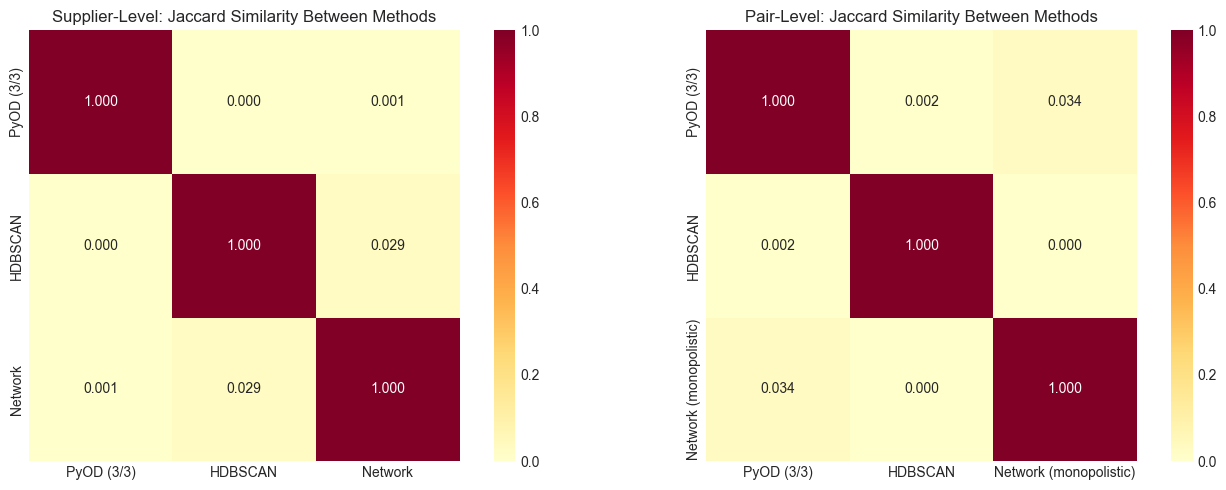


Pair-Level Jaccard Matrix:


,PyOD (3/3),HDBSCAN,Network (monopolistic)
PyOD (3/3),1.000,0.002,0.034
HDBSCAN,0.002,1.000,0.000
Network (monopolistic),0.034,0.000,1.000


In [10]:
# Visualize Jaccard matrices
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Supplier-level
ax = axes[0]
sns.heatmap(supplier_jaccard.astype(float), annot=True, fmt='.3f', 
            cmap='YlOrRd', square=True, ax=ax, vmin=0, vmax=1)
ax.set_title('Supplier-Level: Jaccard Similarity Between Methods')

# Pair-level (if we have enough methods)
ax = axes[1]
pair_method_names = list(pair_methods.keys())
pair_jaccard = pd.DataFrame(
    index=pair_method_names,
    columns=pair_method_names,
    dtype=float
)

for m1, m2 in combinations(pair_method_names, 2):
    j = jaccard_index(pair_methods[m1], pair_methods[m2])
    pair_jaccard.loc[m1, m2] = j
    pair_jaccard.loc[m2, m1] = j

for m in pair_method_names:
    pair_jaccard.loc[m, m] = 1.0

sns.heatmap(pair_jaccard.astype(float), annot=True, fmt='.3f', 
            cmap='YlOrRd', square=True, ax=ax, vmin=0, vmax=1)
ax.set_title('Pair-Level: Jaccard Similarity Between Methods')

plt.tight_layout()
plt.savefig('../results/figures/cross_method_jaccard.png', dpi=150, bbox_inches='tight')
plt.show()

print("\nPair-Level Jaccard Matrix:")
display(pair_jaccard.round(3))

## 7. Top Anomalies for Case Studies

In [11]:
# TOP ANOMALOUS BUYERS (for case study)
print("="*60)
print("TOP ANOMALOUS BUYERS (Case Study Candidates)")
print("="*60)

if high_consensus_buyers:
    top_buyers_df = buyers[buyers['buyer_id'].isin(high_consensus_buyers)].copy()
    top_buyers_df['methods_flagged'] = top_buyers_df['buyer_id'].map(buyer_flag_counts)
    top_buyers_df = top_buyers_df.sort_values('total_value', ascending=False)
    
    print(f"\nTop 20 by total value:")
    display(top_buyers_df.head(20)[[
        'buyer_id', 'buyer_name', 'methods_flagged',
        'total_tenders', 'total_value', 'single_bidder_rate'
    ]])
    
    # Save for case study
    top_buyers_df.to_csv('../results/case_study_buyers.csv', index=False)
    print(f"\nSaved {len(top_buyers_df)} buyers to case_study_buyers.csv")
else:
    print("No high-consensus buyers found")

TOP ANOMALOUS BUYERS (Case Study Candidates)
No high-consensus buyers found


In [12]:
# TOP ANOMALOUS SUPPLIERS
print("="*60)
print("TOP ANOMALOUS SUPPLIERS (Case Study Candidates)")
print("="*60)

if high_consensus_suppliers:
    top_suppliers_df = suppliers[suppliers['supplier_id'].isin(high_consensus_suppliers)].copy()
    top_suppliers_df['methods_flagged'] = top_suppliers_df['supplier_id'].map(supplier_flag_counts)
    top_suppliers_df = top_suppliers_df.sort_values('total_value', ascending=False)
    
    print(f"\nTop 20 by total value:")
    display(top_suppliers_df.head(20)[[
        'supplier_id', 'supplier_name', 'methods_flagged',
        'total_awards', 'total_value'
    ]])
    
    top_suppliers_df.to_csv('../results/case_study_suppliers.csv', index=False)
    print(f"\nSaved {len(top_suppliers_df)} suppliers to case_study_suppliers.csv")
else:
    print("No high-consensus suppliers found")

TOP ANOMALOUS SUPPLIERS (Case Study Candidates)
No high-consensus suppliers found


In [13]:
# TOP ANOMALOUS PAIRS
print("="*60)
print("TOP ANOMALOUS PAIRS (Case Study Candidates)")
print("="*60)

if high_consensus_pairs:
    # Create DataFrame from pairs
    pairs_list = [(b, s, pair_flag_counts[(b, s)]) for b, s in high_consensus_pairs]
    top_pairs_df = pd.DataFrame(pairs_list, columns=['buyer_id', 'supplier_id', 'methods_flagged'])
    
    # Merge with buyer/supplier info
    top_pairs_df = top_pairs_df.merge(
        buyers[['buyer_id', 'buyer_name']], on='buyer_id', how='left'
    ).merge(
        suppliers[['supplier_id', 'supplier_name']], on='supplier_id', how='left'
    )
    
    # Get pair details from PyOD results if available
    if len(pyod_pairs) > 0:
        top_pairs_df = top_pairs_df.merge(
            pyod_pairs, on=['buyer_id', 'supplier_id'], how='left'
        )
    
    top_pairs_df = top_pairs_df.sort_values('methods_flagged', ascending=False)
    
    print(f"\nTop 20 suspicious pairs:")
    display(top_pairs_df.head(20))
    
    top_pairs_df.to_csv('../results/case_study_pairs.csv', index=False)
    print(f"\nSaved {len(top_pairs_df)} pairs to case_study_pairs.csv")
else:
    print("No high-consensus pairs found")

TOP ANOMALOUS PAIRS (Case Study Candidates)

Top 20 suspicious pairs:


,buyer_id,supplier_id,methods_flagged,buyer_name,supplier_name
922,41670394,2650903634,3,СЛУЖБА У СПРАВАХ ДІТЕЙ НОСІВСЬКОЇ МІСЬКОЇ РАДИ,"ФОП ""ФЕДОРОВ ОЛЕКСАНДР ГЕННАДІЙОВИЧ"""
769,26615319,88888888,3,Військова частина А3085,Оборонний постачальник
579,05536515,2680415002,3,"Державний навчальний заклад ""Бердянський машин...",ФОП Стояк Олена Василівна
1225,25452418,3509106452,3,УГЛЯНСЬКИЙ ЛІЦЕЙ ЗІ СТРУКТУРНИМ ПІДРОЗДІЛОМ ГІ...,СТАН ВОЛОДИМИР ІВАНОВИЧ
522,26624436,88888888,3,ВІЙСЬКОВА ЧАСТИНА А7224,Оборонний постачальник
1156,39133192,2516715646,3,ТРУДОВИЙ АРХІВ КОСТОПІЛЬСЬКОЇ МІСЬКОЇ РАДИ,ЮХИМ ЖАННА КОСТЯНТИНІВНА
1081,26395102,2258212959,3,ДУЛІВСЬКИЙ ЗАКЛАД ДОШКІЛЬНОЇ ОСВІТИ (ЯСЛА-САДО...,МАЙОР АНТОН ВАСИЛЬОВИЧ
1080,39067570,88888888,3,"Департамент розвитку громад, будівництва та жи...",Оборонний постачальник
210,30827089,2761705435,3,"КП ""ТЕЛЕКОМПАНІЯ ""ПОДІЛЬСЬКЕ ЕФІРНЕ ТЕЛЕБАЧЕННЯ""",ФОП Грідін Сергій Васильович
649,44763298,3184608081,3,"КУ ""Централізована бухгалтерія з обслуговуванн...",ДАВИД ВІТА МИКОЛАЇВНА



Saved 1725 pairs to case_study_pairs.csv


## 8. Summary Statistics for Thesis

In [14]:
# FINAL SUMMARY FOR THESIS
print("="*70)
print("SUMMARY STATISTICS FOR THESIS CHAPTER 3")
print("="*70)

print("\n### Dataset ###")
print(f"Total buyers: {len(buyers):,}")
print(f"Total suppliers: {len(suppliers):,}")

print("\n### PyOD Aggregated Analysis (IForest + LOF + ECOD) ###")
print(f"Buyer-level high-consensus (3/3): {len(pyod_buyer_set):,}")
print(f"Supplier-level high-consensus (3/3): {len(pyod_supplier_set):,}")
print(f"Pair-level high-consensus (3/3): {len(pyod_pair_set):,}")

print("\n### HDBSCAN Clustering ###")
print(f"Buyer anomalies (top 5%): {len(hdbscan_buyer_set):,}")
print(f"Supplier anomalies (top 5%): {len(hdbscan_supplier_set):,}")

print("\n### Network Analysis ###")
print(f"Suspicious bidders (high connectivity): {len(network_supplier_set):,}")
print(f"Monopolistic relationships: {len(network_pair_set):,}")
print(f"Bid rotation pairs: {len(network_rotation):,}")

print("\n### Cross-Method Consensus ###")
print(f"Buyers flagged by 2+ methods: {len(high_consensus_buyers):,}")
print(f"Suppliers flagged by 3/3 methods: {len(high_consensus_suppliers):,}")
print(f"Pairs flagged by 2+ methods: {len(high_consensus_pairs):,}")

print("\n### Jaccard Index (Method Agreement) ###")
print("Supplier-level:")
for m1, m2 in combinations(supplier_method_names, 2):
    j = jaccard_index(supplier_methods[m1], supplier_methods[m2])
    print(f"  {m1} vs {m2}: {j:.3f}")

print("\nPair-level:")
for m1, m2 in combinations(pair_method_names, 2):
    j = jaccard_index(pair_methods[m1], pair_methods[m2])
    print(f"  {m1} vs {m2}: {j:.3f}")

SUMMARY STATISTICS FOR THESIS CHAPTER 3

### Dataset ###
Total buyers: 35,995
Total suppliers: 358,376

### PyOD Aggregated Analysis (IForest + LOF + ECOD) ###
Buyer-level high-consensus (3/3): 148
Supplier-level high-consensus (3/3): 62
Pair-level high-consensus (3/3): 5,882

### HDBSCAN Clustering ###
Buyer anomalies (top 5%): 1,799
Supplier anomalies (top 5%): 17,918

### Network Analysis ###
Suspicious bidders (high connectivity): 5,394
Monopolistic relationships: 5,266
Bid rotation pairs: 18,126

### Cross-Method Consensus ###
Buyers flagged by 2+ methods: 0
Suppliers flagged by 3/3 methods: 0
Pairs flagged by 2+ methods: 1,725

### Jaccard Index (Method Agreement) ###
Supplier-level:
  PyOD (3/3) vs HDBSCAN: 0.000
  PyOD (3/3) vs Network: 0.001
  HDBSCAN vs Network: 0.029

Pair-level:
  PyOD (3/3) vs HDBSCAN: 0.002
  PyOD (3/3) vs Network (monopolistic): 0.034
  HDBSCAN vs Network (monopolistic): 0.000


In [15]:
# Save summary to file
summary_data = {
    'Metric': [
        'Total buyers',
        'Total suppliers',
        'PyOD buyer consensus (3/3)',
        'PyOD supplier consensus (3/3)',
        'PyOD pair consensus (3/3)',
        'HDBSCAN buyer anomalies',
        'HDBSCAN supplier anomalies',
        'Network suspicious bidders',
        'Network monopolistic pairs',
        'Network rotation pairs',
        'Cross-method buyer consensus',
        'Cross-method supplier consensus',
        'Cross-method pair consensus',
    ],
    'Value': [
        len(buyers),
        len(suppliers),
        len(pyod_buyer_set),
        len(pyod_supplier_set),
        len(pyod_pair_set),
        len(hdbscan_buyer_set),
        len(hdbscan_supplier_set),
        len(network_supplier_set),
        len(network_pair_set),
        len(network_rotation),
        len(high_consensus_buyers),
        len(high_consensus_suppliers),
        len(high_consensus_pairs),
    ]
}

summary_df = pd.DataFrame(summary_data)
summary_df.to_csv('../results/thesis_summary_statistics.csv', index=False)
print("Summary saved to thesis_summary_statistics.csv")
display(summary_df)

Summary saved to thesis_summary_statistics.csv


,Metric,Value
0,Total buyers,35995
1,Total suppliers,358376
2,PyOD buyer consensus (3/3),148
3,PyOD supplier consensus (3/3),62
4,PyOD pair consensus (3/3),5882
5,HDBSCAN buyer anomalies,1799
6,HDBSCAN supplier anomalies,17918
7,Network suspicious bidders,5394
8,Network monopolistic pairs,5266
9,Network rotation pairs,18126


In [16]:
print(f"\nCompleted: {datetime.now().strftime('%Y-%m-%d %H:%M:%S')}")
print("\nNext steps:")
print("1. Review case_study_buyers.csv - select 5-10 for detailed analysis")
print("2. Review case_study_suppliers.csv - select 5-10 for detailed analysis")
print("3. Review case_study_pairs.csv - select 5-10 for detailed analysis")
print("4. Fill in thesis sections 3.5 and 3.6 with these results")


Completed: 2026-02-07 13:32:13

Next steps:
1. Review case_study_buyers.csv - select 5-10 for detailed analysis
2. Review case_study_suppliers.csv - select 5-10 for detailed analysis
3. Review case_study_pairs.csv - select 5-10 for detailed analysis
4. Fill in thesis sections 3.5 and 3.6 with these results
